In [20]:
import os
import io
import pickle
import pandas as pd
import nltk
# `nltk.download('punkt')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from nltk import FreqDist,ngrams
from nltk.corpus import stopwords
import string
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
%matplotlib inline
import plotly as py
import plotly.graph_objs as go
from datetime import datetime
import cufflinks as cf

# set path
direct = "C:/Users/bridge/deda/regrisk/"

In [2]:
# functions

def wordcount(words, dct):
    """Count words in dictionary."""
    from collections import Counter

    counting = Counter(words)
    count = []

    for key, value in counting.items():
        if key in dct:
            count.append([key, value])

    return count

def negwordcount(words, dct, negdct, lngram):
    """Count negated words in dictionary."""
    from nltk.util import ngrams

    mid = int(lngram / 2)
    ng = ngrams(words, lngram)
    nglist = []

    for grams in ng:
        nglist.append(grams)

    keeper = []
    n = len(nglist)
    i = 1
    for grams in nglist:
        if n - i < int(lngram / 2):
            mid = mid + 1

        if grams[mid] in dct:
            for j in grams:
                if j in negdct:
                    keeper.append(grams[mid])
                    break

        i = i + 1

    count = wordcount(keeper, dct)

    return count

def findneg(word, wcneg):
    """Find negation word."""
    keywordneg = 0

    for j in range(0, len(wcneg)):
        if word in wcneg[j][0]:
            keywordneg = wcneg[j][1]
            break

    return keywordneg

def lexcnt(txt, pos_dct, neg_dct, negat_dct, lngram):
    """Count words and negated words in dictionary."""
    from nltk import word_tokenize
    txt = word_tokenize(txt)
    # Count words in lexicon
    pos_wc = wordcount(txt, pos_dct)
    pos_wc = [cnt[1] for cnt in pos_wc]
    pos_wc = sum(pos_wc)

    neg_wc = wordcount(txt, neg_dct)
    neg_wc = [cnt[1] for cnt in neg_wc]
    neg_wc = sum(neg_wc)

    # Count negated words in lexicon
    pos_wcneg = negwordcount(txt, pos_dct, negat_dct, lngram)
    pos_wcneg = [cnt[1] for cnt in pos_wcneg]
    pos_wcneg = sum(pos_wcneg)

    neg_wcneg = negwordcount(txt, neg_dct, negat_dct, lngram)
    neg_wcneg = [cnt[1] for cnt in neg_wcneg]
    neg_wcneg = sum(neg_wcneg)

    pos = pos_wc - (pos_wcneg) + neg_wcneg
    neg = neg_wc - (neg_wcneg) + pos_wcneg

    if pos > neg:
        out = 1
    elif pos < neg:
        out = -1
    else:
        out = 0
    
    return pos, neg

In [3]:
# load data
df = pd.read_csv('C:/Users/bridge/deda/regrisk/NLPnML/df02 - without867.csv',encoding="ISO-8859-1")

In [4]:
negat_dct = ["n't", "not", "never", "no", "neither", "nor", "none"]
lngram = 7

# load lexica
os.chdir(direct + "lexica")

# LM
# negative dictionary (LM)
neg_dct = ""
with io.open("lm_negative.csv", "r", encoding = "utf-8", errors = "ignore") as infile:
    for line in infile:
        neg_dct = neg_dct + line
# saved the lm_negative dictionary in variable neg_dct
neg_dct = neg_dct.split("\n")
neg_dct = [e.lower() for e in neg_dct]   # converted uppercase words to lowercase

# positive dictionary (LM)
pos_dct = ""
with io.open("lm_positive.csv", "r", encoding = "utf-8", errors = "ignore") as infile:
    for line in infile:
        pos_dct = pos_dct + line

pos_dct = pos_dct.split("\n")
pos_dct = [e.lower() for e in pos_dct]

In [5]:
df['comments'].replace(['[]'], [0], inplace=True)
df['comments'] = pd.to_numeric(df['comments'])

In [6]:
%%time
pred = [lexcnt(s, pos_dct, neg_dct, negat_dct, lngram) for s in df["body"]]
pred = pd.DataFrame(pred, columns=('p','n'))

Wall time: 30.1 s


In [7]:
p_train = np.array(pred['p'])
p_train = p_train.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
p_scaled = scaler.fit_transform(p_train) 
pred['p_scaled'] = p_scaled

n_train = np.array(pred['n'])
n_train = n_train.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
n_scaled = scaler.fit_transform(n_train)
pred['n_scaled'] = -n_scaled

pred['sent_body'] = pred[['p_scaled','n_scaled']].mean(axis=1)

s_train = np.array(pred['sent_body'])
s_train = s_train.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(-1,1))
s_scaled = scaler.fit_transform(s_train) 
pred['sent_scaled'] = s_scaled

C:\Users\bridge\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C70BA90>]],
      dtype=object)

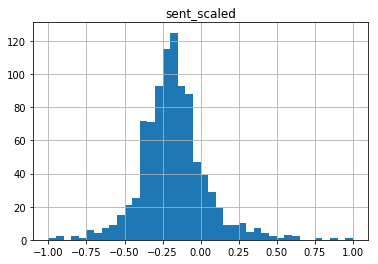

In [11]:
pred.hist(column='sent_scaled',bins=40)

In [8]:
# del(df1)
df1 = df.join(pred['sent_scaled'], how='outer')
df1 = df1.join(pred['p'], how='outer')
df1 = df1.join(pred['n'], how='outer')
df1['date'] = pd.to_datetime(df1['dt'])
del(df1['dt'])
df1 = df1.sort_values('date')


In [11]:
df1.tail()

,title,author,views,shares,body,comments,alltags,sent_scaled,p,n,date,popularity
760,"Bitcoin, Ethereum, Ripple, Bitcoin Cash, EOS, ...",Rakesh Upadhyay,44954,255,The views and opinions expressed here are sole...,3,#Altcoin News #Ethereum News #Ripple ...,-0.312741,12,27,2018-06-07,47534
759,Parity Urges Users to Install Update After Dis...,William Suberg,9963,175,Users of Ethereum software issued by Parity Te...,1,#Altcoin News #Ethereum News #Ethereum...,-0.378378,1,10,2018-06-07,11723
0,SEC Chairman Jay Clayton Says Bitcoin Not a Se...,Molly Jane Zuckerman,21383,422,"Jay Clayton, the chair of the US Securities an...",5,#Bitcoin Regulation #Ethereum News #SE...,-0.238417,1,5,2018-06-07,25653
757,US Regulator Rejects FOIA Request Concerning B...,Molly Jane Zuckerman,15381,190,The US Commodity Futures Trading Commission (C...,0,#Altcoin News #USA #Tether #Bitfine...,-0.574324,1,17,2018-06-08,17281
14,Bitcoin For America: Cryptocurrencies In Campa...,Kirill Bryanov,11030,301,"Last week, Secretary of State of Colorado Wayn...",0,#Bitcoin Regulation #Politics #Electio...,-0.160232,6,11,2018-06-10,14040


In [10]:
df1['date'] = df1['date'].dt.date

# Define a new arbitrary variable to combine views, shares and comments
df1['popularity'] = df1['views'] + (10*(df1['shares'] + df1['comments']))

In [16]:
# del(df1['just_date'])

In [17]:
df1.to_csv('dfsent02.csv')

In [12]:
df1['just_date'] = df1['date']

# Define a new arbitrary variable to combine views, shares and comments
df1['popularity'] = df1['views'] + (10*(df1['shares'] + df1['comments']))

# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df1.loc[x.index, "popularity"])

# Define a dictionary with the functions to apply for a given column:
f = {'popularity': ['sum'], 'sent_scaled': {'weighted_mean' : wm} }

# Groupby and aggregate with your dictionary:
dfsent = df1.groupby(["just_date"]).agg(f)

dfsent.columns = ['Popularity','Sentiment']

C:\Users\bridge\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



In [13]:
dfsent.tail()

,Popularity,Sentiment
just_date,,
2018-06-04,56551,-0.050949
2018-06-05,88790,-0.284239
2018-06-07,110313,-0.255330
2018-06-08,17281,-0.574324
2018-06-10,14040,-0.160232


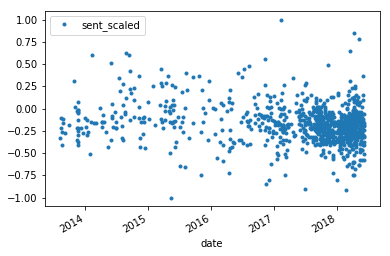

In [16]:
df1.plot(x='date',y='sent_scaled', style='.')

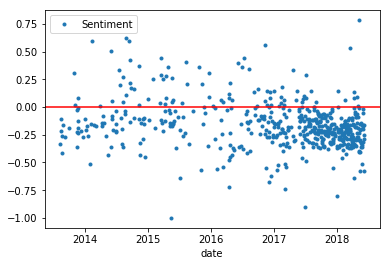

In [14]:
dfsent['date'] = dfsent.index
dfsent.plot(x='date',y='Sentiment', style='.')
plt.axhline(y=0.002, xmin=0, xmax=1, hold=None, color='Red')

In [18]:
# dfsent.to_csv('C:/Users/bridge/deda/regrisk/dfsent.csv')

In [15]:
prices = pd.read_csv('C:/Users/bridge/deda/regrisk/NLPnML/combined_df.csv',encoding="ISO-8859-1")

In [16]:
dfsent.head()

,Popularity,Sentiment,date
just_date,,,
2013-08-08,94,-0.329151,2013-08-08
2013-08-12,106,-0.216216,2013-08-12
2013-08-13,45,-0.104247,2013-08-13
2013-08-20,36,-0.259653,2013-08-20
2013-08-22,38,-0.413127,2013-08-22


In [21]:
# dfsent_2015 = dfsent.loc['2015-01-01':'2018-05-31']
fig1 = dfsent.iplot(columns=['BTC'], asFigure=True)
fig2 = dfsent.iplot(columns=['Sentiment'], kind='bar', secondary_y=['Sentiment'], asFigure=True)
fig2['data'].extend(fig1['data'])
py.offline.plot(fig2)

KeyError: 'BTC'